In [31]:
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import itertools

In [14]:
# Data directories and parameters
Datadirectory = "C:\\Users\\Moham\\Downloads\\archive"
Classes = ["0", "1", "2", "3", "4", "5", "6"]
img_size = 128
batch_size = 32

In [15]:
# Define the path to your training data
train_data_path = os.path.join(Datadirectory, "train")

# Get the list of all image files in the training data directory
all_image_files = []
for class_label in Classes:
    class_path = os.path.join(train_data_path, class_label)
    image_files = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(".jpg")]
    all_image_files.extend(image_files)

# Create labels for each image based on the class folders
all_labels = [Classes[int(os.path.basename(os.path.dirname(img)))] for img in all_image_files]

# Create a DataFrame with file paths and labels
df = pd.DataFrame({'filepath': all_image_files, 'label': all_labels})

# Split the data into training and validation sets
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

# Data generators for training and validation with reduced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',
    classes=Classes
)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='filepath',
    y_col='label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',
    classes=Classes
)

Found 22967 validated image filenames belonging to 7 classes.
Found 5742 validated image filenames belonging to 7 classes.


In [16]:
# Pretrained MobileNetV2 model
model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

In [17]:
# Unfreeze some layers of the pretrained model
for layer in model.layers[-20:]:
    layer.trainable = True

In [18]:
# Build the new model
base_output = model.output
flatten = layers.Flatten()(base_output)
dense1 = layers.Dense(128, activation='relu')(flatten)
batch_norm = layers.BatchNormalization()(dense1)
dropout = layers.Dropout(0.5)(batch_norm)
final_output = layers.Dense(len(Classes), activation='softmax')(dropout)

new_model = tf.keras.models.Model(inputs=model.input, outputs=final_output)

In [19]:
# Learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

In [20]:
# Compile the model
new_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["accuracy"]
)

In [21]:
# EarlyStopping to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [23]:
# Train the model with data augmentation
history = new_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
718/718 [==============================] - 754s 1s/step - loss: 1.2037 - accuracy: 0.5512 - val_loss: 1.9034 - val_accuracy: 0.4364
Epoch 2/20
718/718 [==============================] - 823s 1s/step - loss: 1.1260 - accuracy: 0.5845 - val_loss: 1.9472 - val_accuracy: 0.4535
Epoch 3/20
718/718 [==============================] - 891s 1s/step - loss: 1.0830 - accuracy: 0.5999 - val_loss: 2.4674 - val_accuracy: 0.3638
Epoch 4/20
718/718 [==============================] - 802s 1s/step - loss: 1.0521 - accuracy: 0.6132 - val_loss: 1.6917 - val_accuracy: 0.4749
Epoch 5/20
718/718 [==============================] - 769s 1s/step - loss: 1.0311 - accuracy: 0.6198 - val_loss: 1.3137 - val_accuracy: 0.5432
Epoch 6/20
718/718 [==============================] - 767s 1s/step - loss: 1.0019 - accuracy: 0.6326 - val_loss: 1.3829 - val_accuracy: 0.5618
Epoch 7/20
718/718 [==============================] - 775s 1s/step - loss: 0.9743 - accuracy: 0.6426 - val_loss: 1.4786 - val_accuracy: 0.4958

In [24]:
# Testing the model
testing_datagen = ImageDataGenerator(rescale=1./255)

test_generator = testing_datagen.flow_from_directory(
    "C:\\Users\\Moham\\Downloads\\archive\\test",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',  # for sparse categorical crossentropy
    classes=Classes
)

# Evaluate the model using the generator
new_model.evaluate(test_generator)

Found 7178 images belonging to 7 classes.
225/225 [==============================] - 138s 615ms/step - loss: 1.1158 - accuracy: 0.6328


[1.1157588958740234, 0.6327667832374573]

In [33]:
# Save the model
new_model.save("C:\\Users\\Moham\\OneDrive\\Desktop\\AI\\emotion_classifier_final_v.h5")

C:\Users\Moham\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
new_model= tf.keras.models.load_model("C:\\Users\\Moham\\OneDrive\\Desktop\\AI\\emotion_classifier_final_v.h5")

In [25]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
def plot_roc_curves(y_true, y_pred, classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()


In [26]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


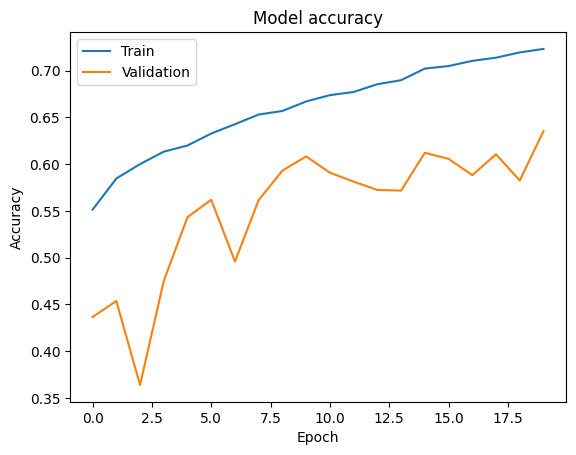

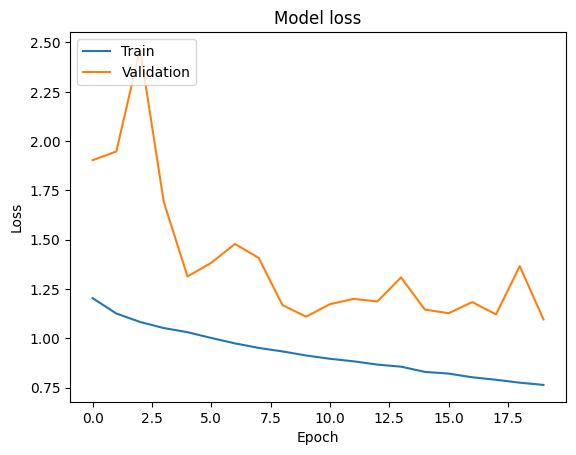

In [27]:
# Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


225/225 [==============================] - 84s 374ms/step


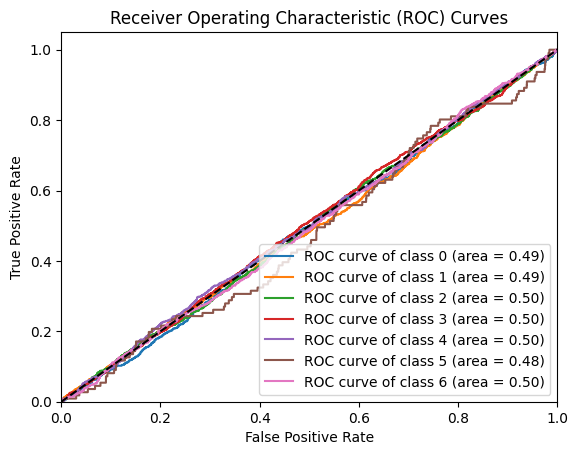

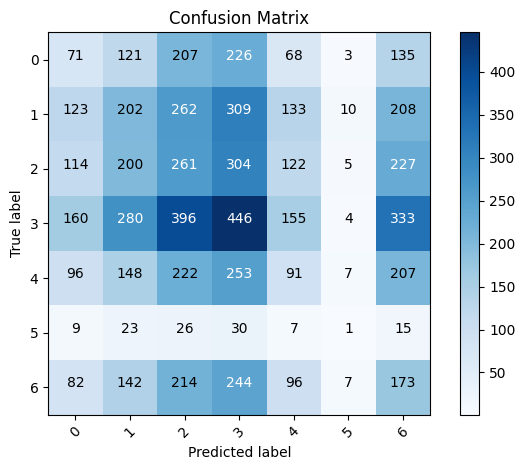

In [32]:
# Get the actual labels and predicted probabilities
testY_actual = test_generator.classes
predictions = new_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Convert to one-hot encoding for ROC curve plotting
testY_actual_one_hot = to_categorical(testY_actual)

# Plot ROC curves
plot_roc_curves(testY_actual_one_hot, predictions, Classes)

# Plot confusion matrix
plot_confusion_matrix(testY_actual, predicted_classes, Classes)
